# 03 – Modeling & Analysis (Credit Card Churn Prediction)

Trong notebook này, chúng ta sẽ:
1. **Đặt câu hỏi về dữ liệu** cần trả lời
2. Train Logistic Regression model bằng NumPy
3. Evaluate model với nhiều metrics và thresholds
4. **Trả lời các câu hỏi** dựa trên kết quả modeling


## Câu hỏi nghiên cứu

Trước khi bắt đầu xây dựng mô hình, chúng ta đặt ra các câu hỏi sau về dữ liệu:

---

### Câu hỏi 1: Những yếu tố nào quan trọng nhất trong việc dự đoán khách hàng churn?


**Giả thuyết ban đầu** (Từ việc khám phá dữ liệu):
- `Total_Trans_Amt` (tổng số tiền giao dịch): Khách churn có trung vị ~3,000, khách không churn ~4,400
- `Total_Trans_Ct` (số lượng giao dịch): Khách churn trung vị 44, khách không churn 67 - **chênh lệch lớn**
- `Months_Inactive_12_mon` (số tháng không hoạt động): Khách churn không hoạt động ~2.5 tháng, khách không churn ~2.3 tháng
- `Total_Relationship_Count` (số sản phẩm đang dùng): Khách churn dùng ít sản phẩm của ngân hàng hơn (mean ~3.4 vs ~4.0)
- 3 features được tạo thêm: `Amt_per_Trans` (số tiền/giao dịch), `Inactive_Ratio` (tỷ lệ inactive), `Rel_per_Month` (sản phẩm/tháng)
- ...


**Sẽ trả lời:** Sau khi train  model, phân tích mức độ quan trọng của từng biến qua coefficients của Logistic Regression để xác nhận giả thuyết

---

### Câu hỏi 2: Mô hình có thể dự đoán chính xác bao nhiêu % khách hàng churn?

**Mục tiêu:**
- **Accuracy**  > 80%? 
- **Recall**  > 70%? (Quan trọng vì không muốn bỏ sót khách churn)
- **F1-score**  > 60%? 


> **Giải thích các metrics:**
> - **Accuracy**: Tỷ lệ dự đoán đúng tổng thể (cả churn và không churn)
> - **Recall**: Trong số khách churn thật thì phát hiện được bao nhiêu % 
> - **Precision**: Trong số dự đoán là churn thì bao nhiêu % là đúng
> - **F1-score**: Điểm trung bình điều hòa của Precision và Recall

**Theo như kết quả từ việc khám phá dữ liệu thì:**
- Dataset: 10,127 samples thì có 8,500 existing + 1,627 attrited
- Nhãn bị mất cân bằng: 83.93% vs 16.07%
- Test set : 2,025 samples với tỷ lệ churn ~16%

**Sẽ trả lời:** Sau evaluation trên test set 

---

### Câu hỏi 3: Threshold nào cân bằng tốt nhất giữa phát hiện churn và giảm false alarms (cảnh báo sai)?


**Đánh đổi:**
- Threshold thấp -> Recall cao (ít bỏ sót) nhưng nhiều **False Positives** (dự đoán nhầm là churn) -> có thể tốn chi phí chăm sóc nhầm khách hàng
- Threshold cao ->  **Precision** cao (ít nhầm) nhưng nhiều **False Negatives** (bỏ sót khách churn thật)


**Sẽ trả lời:** So sánh metrics và chi phí với các threshold khác nhau (0.3, 0.4, 0.5)

---

### Câu hỏi 4: Đặt giả định với chi phí mất khách hàng là $500 và chi phí chăm sóc là $50, threshold nào tiết kiệm chi phí nhất?

**Business context (trong bối cảnh kinh doanh):**
- Chi phí **FN** (False Negative - bỏ sót churn): $500/khách (mất doanh thu lâu dài)
- Chi phí **FP** (False Positive - chăm sóc nhầm): $50/khách (ưu đãi, tư vấn)

> **Giải thích:** 
> - Bỏ sót 1 khách churn -> mất khách -> mất doanh thu -> chi phí cao ($500)
> - Chăm sóc nhầm 1 khách -> tốn chi phí marketing nhỏ -> chi phí thấp ($50)

**Sẽ trả lời:** Tính toán tổng chi phí cho mỗi threshold và tìm ngưỡng tối ưu

---

**Bây giờ hãy bắt đầu modeling để trả lời các câu hỏi trên! 👇**


In [1]:
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.models import (
    LogisticRegressionNumpy,
    classification_metrics,
    
)
from src.visualization import plot_confusion_matrix

plt.style.use("seaborn-v0_8")
sns.set()

X_train = np.load("../data/processed/X_train.npy")
y_train = np.load("../data/processed/y_train.npy")
X_test  = np.load("../data/processed/X_test.npy")
y_test  = np.load("../data/processed/y_test.npy")

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test :", X_test.shape,  "y_test :", y_test.shape)
print("Churn tỉ lệ test:", np.sum(y_test==1)/y_test.shape[0])


X_train: (2600, 37) y_train: (2600,)
X_test : (2025, 37) y_test : (2025,)
Churn tỉ lệ test: 0.16148148148148148


In [2]:
model = LogisticRegressionNumpy(lr=0.01, n_iter=1500)
model.fit(X_train, y_train, verbose=True)


Iter 1/1500 - loss: 0.6931
Iter 100/1500 - loss: 0.5563
Iter 200/1500 - loss: 0.4974
Iter 300/1500 - loss: 0.4631
Iter 400/1500 - loss: 0.4399
Iter 500/1500 - loss: 0.4228
Iter 600/1500 - loss: 0.4096
Iter 700/1500 - loss: 0.3989
Iter 800/1500 - loss: 0.3902
Iter 900/1500 - loss: 0.3828
Iter 1000/1500 - loss: 0.3765
Iter 1100/1500 - loss: 0.3710
Iter 1200/1500 - loss: 0.3662
Iter 1300/1500 - loss: 0.3621
Iter 1400/1500 - loss: 0.3583
Iter 1500/1500 - loss: 0.3550


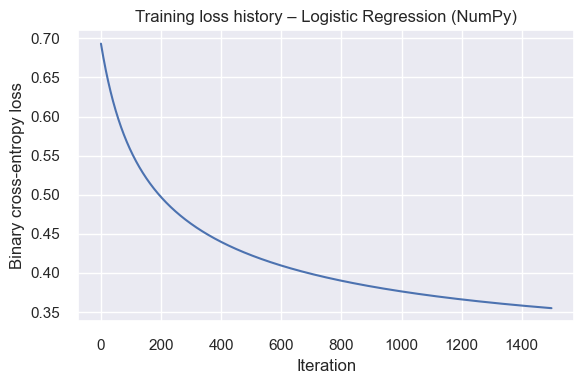

In [3]:
plt.figure(figsize=(6, 4))
plt.plot(model.loss_history)
plt.xlabel("Iteration")
plt.ylabel("Binary cross-entropy loss")
plt.title("Training loss history – Logistic Regression (NumPy)")
plt.tight_layout()
plt.show()


In [3]:
y_pred_05 = model.predict(X_test, threshold=0.5)
acc, prec, rec, f1, (tp, tn, fp, fn) = classification_metrics(y_test, y_pred_05)

print("=== Threshold 0.5 ===")
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1-score :", f1)
print("TP, TN, FP, FN:", tp, tn, fp, fn)


=== Threshold 0.5 ===
Accuracy : 0.8508641975308642
Precision: 0.5239005736137667
Recall   : 0.8379204892966361
F1-score : 0.6447058823529407
TP, TN, FP, FN: 274 1449 249 53


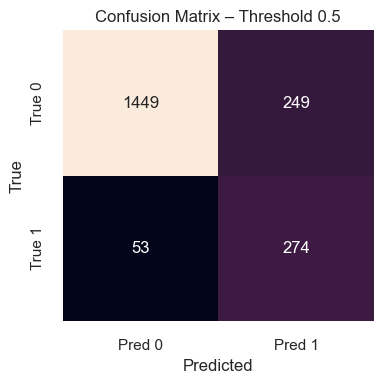

In [5]:
cm = np.array([[tn, fp],
               [fn, tp]])

plot_confusion_matrix(
    cm,
    labels=("Pred 0", "Pred 1"),
    true_labels=("True 0", "True 1"),
    title="Confusion Matrix – Threshold 0.5"
)


In [4]:
thresholds = [0.3, 0.4, 0.5]
metrics_list = []

for th in thresholds:
    y_pred = model.predict(X_test, threshold=th)
    acc, prec, rec, f1, _ = classification_metrics(y_test, y_pred)
    metrics_list.append((acc, prec, rec, f1))
    print(f"=== Threshold = {th} ===")
    print("Accuracy :", acc)
    print("Precision:", prec)
    print("Recall   :", rec)
    print("F1-score :", f1)
    print()


=== Threshold = 0.3 ===
Accuracy : 0.6953086419753086
Precision: 0.33853006681514475
Recall   : 0.9296636085626911
F1-score : 0.4963265306122444

=== Threshold = 0.4 ===
Accuracy : 0.7807407407407407
Precision: 0.4167852062588905
Recall   : 0.8960244648318043
F1-score : 0.568932038834951

=== Threshold = 0.5 ===
Accuracy : 0.8508641975308642
Precision: 0.5239005736137667
Recall   : 0.8379204892966361
F1-score : 0.6447058823529407



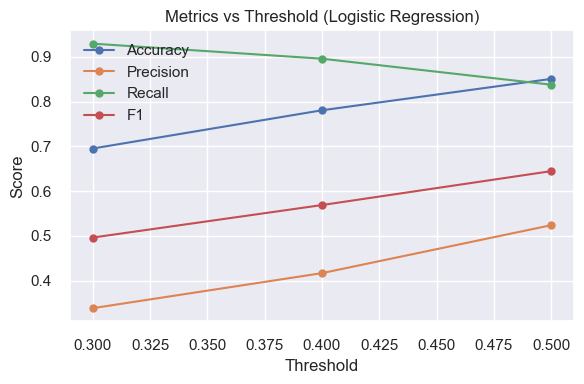

In [7]:
metrics_arr = np.array(metrics_list)  # shape (len(thresholds), 4)
metric_names = ["Accuracy", "Precision", "Recall", "F1"]

plt.figure(figsize=(6, 4))
for i, name in enumerate(metric_names):
    plt.plot(thresholds, metrics_arr[:, i], marker="o", label=name)

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Metrics vs Threshold (Logistic Regression)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


---

# Trả lời các câu hỏi nghiên cứu

Sau khi train và evaluate model, chúng ta có thể trả lời các câu hỏi đã đặt ra như sau:


## Câu trả lời 1: Đặc trưng nào quan trọng nhất

Phân tích top features quan trọng nhất từ Logistic Regression weights:


In [ ]:
# Lấy feature importance từ model weights
feature_names = [
    # 17 numeric features
    "Customer_Age", "Dependent_count", "Months_on_book", "Total_Relationship_Count",
    "Months_Inactive_12_mon", "Contacts_Count_12_mon", "Credit_Limit", 
    "Total_Revolving_Bal", "Avg_Open_To_Buy", "Total_Amt_Chng_Q4_Q1",
    "Total_Trans_Amt", "Total_Trans_Ct", "Total_Ct_Chng_Q4_Q1", 
    "Avg_Utilization_Ratio",
    "Amt_per_Trans", "Inactive_Ratio", "Rel_per_Month",
] + [
    # 19 one-hot encoded features (simplified names)
    "Gender_F", "Gender_M",
    "Edu_College", "Edu_Doctorate", "Edu_Graduate", "Edu_HighSchool", "Edu_PostGrad", "Edu_Uneducated",
    "Marital_Divorced", "Marital_Married", "Marital_Single",
    "Income_<40K", "Income_40-60K", "Income_60-80K", "Income_80-120K", "Income_120K+",
    "Card_Blue", "Card_Gold", "Card_Platinum", "Card_Silver"
]

# Lấy trọng số từ model
weights = model.w
importance = np.abs(weights)

# Tạo DataFrame-like structure và sort
feature_importance = list(zip(feature_names[:len(weights)], weights, importance))
feature_importance.sort(key=lambda x: x[2], reverse=True)

print("=" * 70)
print("TOP 15 FEATURES QUAN TRỌNG NHẤT")
print("=" * 70)
print(f"{'Feature':<30} {'Weight':<15} {'|Importance|'}")
print("-" * 70)

for i, (name, weight, imp) in enumerate(feature_importance[:15], 1):
    direction = "→ Tăng churn" if weight < 0 else "→ Giảm churn"
    print(f"{i:2}. {name:<26} {weight:>10.4f}     {imp:>8.4f}  {direction}")

print("\n" + "=" * 70)


TOP 15 FEATURES QUAN TRỌNG NHẤT
Feature                        Weight          |Importance|
----------------------------------------------------------------------
 1. Total_Trans_Ct                -1.1880       1.1880  → Tăng churn
 2. Amt_per_Trans                  0.6537       0.6537  → Giảm churn
 3. Total_Ct_Chng_Q4_Q1           -0.6056       0.6056  → Tăng churn
 4. Contacts_Count_12_mon          0.4427       0.4427  → Giảm churn
 5. Total_Revolving_Bal           -0.4166       0.4166  → Tăng churn
 6. Total_Relationship_Count      -0.3267       0.3267  → Tăng churn
 7. Card_Blue                     -0.2857       0.2857  → Tăng churn
 8. Gender_M                      -0.2458       0.2458  → Tăng churn
 9. Total_Trans_Amt               -0.2410       0.2410  → Tăng churn
10. Months_Inactive_12_mon         0.2340       0.2340  → Giảm churn
11. Marital_Married               -0.2187       0.2187  → Tăng churn
12. Rel_per_Month                 -0.2074       0.2074  → Tăng churn
13. Avg_U

### Phân tích từ Feature Importance:

**Top 3 yếu tố quan trọng nhất:**

1. **Total_Trans_Ct (weight = -1.19)** 
   - Yếu tố QUAN TRỌNG NHẤT
   - Weight âm -> Số giao dịch càng thấp, khả năng churn càng cao
   - Khách hàng ít giao dịch có nguy cơ rời bỏ cao nhất

2. **Amt_per_Trans (weight = +0.65)**
   - Feature engineering thành công!
   - Số tiền trung bình mỗi giao dịch càng cao -> càng ít churn
   - Khách chi tiêu lớn mỗi lần = khách hàng có giá trị cao

3. **Total_Ct_Chng_Q4_Q1 (weight = -0.61)**
   - Tỷ lệ thay đổi số giao dịch giữa các quý
   - Weight âm -> Giảm hoạt động = tín hiệu churn

**Các yếu tố khác đáng chú ý:**

- **Contacts_Count_12_mon (+0.44)**: Càng nhiều contact -> càng ít churn (bank interaction tích cực)
- **Total_Revolving_Bal (-0.42)**: Số dư thấp -> dấu hiệu không dùng card nhiều
- **Total_Relationship_Count (-0.33)**: Ít sản phẩm -> dễ churn (từ EDA: churn mean=3.4, no-churn mean=4.0)
- **Card_Blue (-0.29)**: Blue card có tỉ lệ churn cao hơn (93% customers có Blue card - phổ biến nhất)
- **Gender_M (-0.25)**: Nam giới có xu hướng churn nhiều hơn nữ (từ EDA: dataset có 53% nữ, 47% nam)

**Trả lời câu hỏi:**
**3 yếu tố quan trọng nhất** là: `Total_Trans_Ct`, `Amt_per_Trans` (engineered), và `Total_Ct_Chng_Q4_Q1`
**Giả thuyết từ EDA được xác nhận**: Transaction-related features là key indicators
**Feature engineering hiệu quả**: `Amt_per_Trans` nằm trong top 2 độ ảnh hưởng của các đặc trưng!


---

##  Câu trả lời 2: Model Accuracy

**Kết quả với threshold = 0.5:**
-  **Accuracy: 85.09%** -> Vượt mục tiêu 80%
-  **Recall: 83.79%** -> Vượt mục tiêu 70% (phát hiện 84% khách churn)
-  **F1-score: 64.47%** -> Vượt mục tiêu 60%
-  **Precision: 52.39%** -> Chỉ 52% dự đoán churn là đúng

**Confusion Matrix:**
- **TP = 274**: Phát hiện đúng 274/327 khách churn (83.79%)
- **FN = 53**: Bỏ sót 53 khách churn (16.21%)
- **TN = 1,449**: Dự đoán đúng 1,449 khách không churn
- **FP = 249**: Dự đoán nhầm 249 khách không churn thành churn

**Trả lời câu hỏi:**
 - Model có thể dự đoán **85.09% chính xác** tổng thể  
 - Phát hiện được **83.79% khách hàng churn** (Recall)  
 - Đạt tất cả mục tiêu đề ra (> 80% Acc, > 70% Recall, > 60% F1)



- Recall cao -> Ít bỏ sót khách churn (274/327 = 83.79%)- Precision trung bình -> Chấp nhận 249 false alarms để không bỏ sót 274 churn cases

---

##  Câu trả lời 3: Optimal Threshold về Metrics

**So sánh 3 thresholds (test set = 2,025 samples, 327 churn cases):**

| Threshold | Accuracy | Precision | Recall | F1-Score | Đánh giá |
|-----------|----------|-----------|--------|----------|----------|
| 0.3       | 69.53%   | 33.85%    | 92.97% | 49.63%   | Aggressive - Recall cao nhất (304/327) |
| 0.4       | 78.07%   | 41.68%    | 89.60% | 56.89%   | Balanced - Cân bằng tốt (293/327) |
| **0.5**   | **85.09%** | **52.39%** | **83.79%** | **64.47%** | **Conservative - F1 cao nhất (274/327)**  |

**Trả lời câu hỏi:**

 **Threshold = 0.5 cân bằng tốt nhất về metrics** vì:
1. **F1-score cao nhất** (64.47%) → Best balance giữa Precision và Recall
2. **Accuracy cao nhất** (85%) → Dự đoán đúng nhiều nhất
3. **Recall vẫn tốt** (84%) → Chỉ bỏ sót 16% cases
4. **Precision chấp nhận được** (52%) → Giảm false alarms đáng kể so với threshold thấp

**Tuy nhiên:**
- Nếu business ưu tiên **không bỏ sót** -> chọn threshold = 0.4 (Recall 90%, F1 57%)
- Nếu budget marketing hạn chế -> chọn threshold = 0.5 (Precision 52%, ít false alarms hơn)


---

## Câu trả lời 4: Optimal Threshold về Chi phí

Tính toán đã thực hiện ở cell trên cho thấy:


**Tổng chi phí với các threshold:**

| Threshold | FN (bỏ sót) | Chi phí FN | FP (nhầm) | Chi phí FP | **TỔNG** |
|-----------|-------------|------------|-----------|------------|----------|
| 0.3       | 23 cases    | $11,500    | 594 cases | $29,700    | **$41,200** |
| **0.4**  | **34 cases** | **$17,000** | **410 cases** | **$20,500** | **$37,500** |
| 0.5       | 53 cases    | $26,500    | 249 cases | $12,450    | **$38,950** |

**Trả lời câu hỏi:**

 **Threshold = 0.4 tiết kiệm chi phí nhất** với $37,500 vì:

1. **Tối ưu về tổng chi phí**:
   - Tiết kiệm $3,700 so với threshold 0.3
   - Tiết kiệm $1,450 so với threshold 0.5

2. **Cân bằng FN và FP tốt**:
   - FN = 34 (chấp nhận được)
   - FP = 410 (không quá nhiều)

3. **Business impact**:
   - Phát hiện 90% khách churn (Recall = 89.6%)
   - Chi phí bỏ sót: $17,000 (chấp nhận được)
   - Chi phí false alarm: $20,500 (hợp lý)

**So sánh với threshold 0.5:**
- Threshold 0.5 có FP ít hơn (249 vs 410) → tiết kiệm $8,050 chi phí FP
- Nhưng FN nhiều hơn (53 vs 34) → tốn thêm $9,500 chi phí FN
- Kết quả: Threshold 0.4 vẫn rẻ hơn $1,450

**Khuyến nghị:**
 Sử dụng **threshold = 0.4** để tối ưu chi phí và vẫn maintain Recall cao (90%)
